**COMPUTER VISION - ASSIGNMENT 6**

Sadwi Kandula 

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Conv2D layer
class conv2d_CV:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # Initialize the filter bank weights randomly
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size)
        
    def forward(self, X):
        batch_size, in_height, in_width, in_channels = X.shape
        out_height = int(((in_height + 2*self.padding - self.kernel_size) / self.stride) + 1)
        out_width = int(((in_width + 2*self.padding - self.kernel_size) / self.stride) + 1)
        out = np.zeros((batch_size, out_height, out_width, self.out_channels))
        padded_X = np.pad(X, ((0, 0), (self.padding, self.padding), (self.padding, self.padding), (0, 0)), mode='constant')
        
        for h in range(out_height):
            for w in range(out_width):
                h_start = h * self.stride
                w_start = w * self.stride
                h_end = h_start + self.kernel_size
                w_end = w_start + self.kernel_size
                window = padded_X[:, h_start:h_end, w_start:w_end, :]
                for c in range(self.out_channels):
                    out[:, h, w, c] = np.sum(window * self.weights[c, :, :, :], axis=(1, 2, 3))
                    
        return out
    
    def backward(self, X, grad_output, learning_rate):
        batch_size, in_height, in_width, in_channels = X.shape
        _, out_height, out_width, out_channels = grad_output.shape
        padded_X = np.pad(X, ((0, 0), (self.padding, self.padding), (self.padding, self.padding), (0, 0)), mode='constant')
        padded_grad_input = np.zeros_like(padded_X)
        grad_weights = np.zeros_like(self.weights)
        
        for h in range(out_height):
            for w in range(out_width):
                h_start = h * self.stride
                w_start = w * self.stride
                h_end = h_start + self.kernel_size
                w_end = w_start + self.kernel_size
                window = padded_X[:, h_start:h_end, w_start:w_end, :]
                for c in range(out_channels):
                    grad_weights[c, :, :, :] += np.sum(
                        window * grad_output[:, h, w, c][:, None, None, None], axis=0)
                for b in range(batch_size):
                    padded_grad_input[b, h_start:h_end, w_start:w_end, :] += np.sum((self.weights[:, :, :, :] * grad_output[b, h, w, :][:, None, None, None]), axis=0)

                # Remove padding
                grad_input = padded_grad_input[:, self.padding:-self.padding, self.padding:-self.padding, :]
        
                # Update weights
                self.weights -= learning_rate * grad_weights / batch_size

                return grad_input



In [80]:
class max_pool_2d_CV:
    def __init__(self, pool_size, stride=1):
        self.pool_size = pool_size
        self.stride = stride
        
    def forward(self, X):
        batch_size, in_height, in_width, in_channels = X.shape
        out_height = int(((in_height - self.pool_size) / self.stride) + 1)
        out_width = int(((in_width - self.pool_size) / self.stride) + 1)
        out = np.zeros((batch_size, out_height, out_width, in_channels))
        
        for h in range(out_height):
            for w in range(out_width):
                h_start = h * self.stride
                w_start = w * self.stride
                h_end = h_start + self.pool_size
                w_end = w_start + self.pool_size
                window = X[:, h_start:h_end, w_start:w_end, :]
                out[:, h, w, :] = np.max(window, axis=(1, 2))
                
        return out
    
    def backward(self, X, grad_output):
        batch_size, in_height, in_width, in_channels = X.shape
        _, out_height, out_width, _ = grad_output.shape
        grad_input = np.zeros_like(X)
        
        for h in range(out_height):
            for w in range(out_width):
                h_start = h * self.stride
                w_start = w * self.stride
                h_end = h_start + self.pool_size
                w_end = w_start + self.pool_size
                window = X[:, h_start:h_end, w_start:w_end, :]
                grad_pool = grad_output[:, h, w, :, None, None]
                grad_mask = (window == np.max(window, axis=(1, 2))[:, None, None, :])
                grad_input[:, h_start:h_end, w_start:w_end, :] += grad_pool * grad_mask
                
        return grad_input


In [81]:
class Layer:
    def __init__(self):
        self.trainable = True

    def forward(self, inputs):
        raise NotImplementedError

    def backward(self, grad):
        raise NotImplementedError

    def update_params(self, learning_rate):
        pass

    def set_trainable(self, trainable):
        self.trainable = trainable


In [82]:
class Flatten(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        self.batch_size, *self.input_shape = inputs.shape
        return inputs.reshape(self.batch_size, -1)

    def backward(self, grad):
        return grad.reshape(self.batch_size, *self.input_shape)


In [83]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2.0 / (input_size + output_size))
        self.biases = np.zeros(output_size)

    def forward(self, inputs):
        self.inputs = inputs
        return np.dot(inputs, self.weights) + self.biases

    def backward(self, grad):
        grad_inputs = np.dot(grad, self.weights.T)
        grad_weights = np.dot(self.inputs.T, grad)
        grad_biases = np.sum(grad, axis=0)
        self.weights -= self.learning_rate * grad_weights
        self.biases -= self.learning_rate * grad_biases
        return grad_inputs



In [84]:
class ReLU(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        self.inputs = inputs
        return np.maximum(0, inputs)

    def backward(self, grad):
        grad[self.inputs <= 0] = 0
        return grad


In [ ]:
class Softmax(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        exp_inputs = np.exp(inputs - np.max(inputs, axis=-1, keepdims=True))
        return exp_inputs / np.sum(exp_inputs, axis=-1, keepdims=True)

    def backward(self, grad):
        s = self.output.reshape((-1, 1))
        return s * (grad - np.sum(grad * s, axis=1, keepdims=True))


In [ ]:
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

# Reshape the data to add a channel dimension
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

# Define the model architecture
model = [
    conv2d_CV(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    max_pool_2d_CV(pool_size=2, stride=2),
    conv2d_CV(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    max_pool_2d_CV(pool_size=2, stride=2),
    Flatten(),
    Dense(7*7*64, 128),
    ReLU(),
    Dense(128, 10),
    Softmax()
]

In [85]:
class Model:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, inputs):
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def update_params(self, learning_rate):
        for layer in self.layers:
            if isinstance(layer, TrainableLayer):
                layer.update_params(learning_rate)

    def get_params(self):
        params = []
        for layer in self.layers:
            if isinstance(layer, TrainableLayer):
                params.append(layer.get_params())
        return params


In [86]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, ReLU, Softmax
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np


class Model:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, inputs):
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, grads):
        for layer in reversed(self.layers):
            grads = layer.backward(grads)
        return grads


class Conv2DLayer:
    def __init__(self, filter_shape, num_filters, stride=1, padding='VALID'):
        self.filter_shape = filter_shape
        self.num_filters = num_filters
        self.stride = stride
        self.padding = padding
        self.filters = np.random.randn(filter_shape[0], filter_shape[1], filter_shape[2], num_filters)

    def forward(self, inputs):
        self.inputs = inputs
        batch_size, input_height, input_width, input_channels = inputs.shape
        output_height = int((input_height - self.filter_shape[0]) / self.stride) + 1
        output_width = int((input_width - self.filter_shape[1]) / self.stride) + 1
        self.outputs = np.zeros((batch_size, output_height, output_width, self.num_filters))
        for i in range(output_height):
            for j in range(output_width):
                receptive_field = inputs[:, i * self.stride:i * self.stride + self.filter_shape[0],
                                          j * self.stride:j * self.stride + self.filter_shape[1], :]
                for k in range(self.num_filters):
                    self.outputs[:, i, j, k] = np.sum(receptive_field * self.filters[:, :, :, k], axis=(1, 2, 3))
        return self.outputs

    def backward(self, grads):
        batch_size, input_height, input_width, input_channels = self.inputs.shape
        output_height, output_width, output_channels = grads.shape
        delta = np.zeros_like(self.inputs)
        delta_filters = np.zeros_like(self.filters)
        for i in range(output_height):
            for j in range(output_width):
                receptive_field = self.inputs[:, i * self.stride:i * self.stride + self.filter_shape[0],
                                          j * self.stride:j * self.stride + self.filter_shape[1], :]
                for k in range(output_channels):
                    delta[:, i * self.stride:i * self.stride + self.filter_shape[0],
                          j * self.stride:j * self.stride + self.filter_shape[1], :] += (
                            grads[:, i, j, k] * self.filters[:, :, :, k][None, :, :, :])
                    delta_filters[:, :, :, k] += np.sum(
                        receptive_field * grads[:, i, j, k][:, None, None, None], axis=0)
        self.filters -= delta_filters * 0.01
        return delta


class ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        return np.maximum(0, inputs)

    def backward(self, grads):
        grads[self.inputs <= 0] = 0
        return grads





In [87]:
class Dense:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size)
        self.bias = np.zeros(output_size)

    def forward(self, inputs):
        # Compute the output of the dense layer
        outputs = np.dot(inputs, self.weights) + self.bias
        return outputs


In [88]:
def train(model, train_dataset, num_epochs, learning_rate):
    # Define loss function and optimizer
    loss_fn = CategoricalCrossentropy()
    optimizer = SGD(learning_rate=learning_rate)

    # Create empty lists to store loss and filter history
    loss_history = []
    filter_history = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in train_dataset:
            with tf.GradientTape() as tape:
                # Forward pass
                logits = model(images)

                # Compute loss
                loss_value = loss_fn(labels, logits)

            # Backward pass
            gradients = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            epoch_loss += loss_value.numpy()
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        loss_history.append(avg_loss)

        # Record filter weights every epoch
        filter_history.append(model.conv1.get_weights()[0])

        print("Epoch {}: loss = {}".format(epoch+1, avg_loss))

    return loss_history, filter_history



In [94]:
@tf.function
def train_step(model, images, labels, loss_fn, optimizer):
    with tf.GradientTape() as tape:
        # Make a prediction on all the batch
        logits = model(images, training=True)

        # Remove the extra dimension from labels
        labels = tf.squeeze(labels)

        # Compute loss
        loss = loss_fn(labels, logits)

    # Compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    # Update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Compute the accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, axis=1), tf.argmax(labels, axis=1)), tf.float32))

    return loss, accuracy


4422102/4422102 [==============================] - 0s 0us/step
Epoch 1: Loss = 0.7512474060058594
Epoch 2: Loss = 0.5142683982849121
Epoch 3: Loss = 0.46832725405693054
Epoch 4: Loss = 0.44407033920288086
Epoch 5: Loss = 0.4256187081336975
Epoch 6: Loss = 0.41127291321754456
Epoch 7: Loss = 0.3990212678909302
Epoch 8: Loss = 0.3894798755645752
Epoch 9: Loss = 0.3803196847438812
Epoch 10: Loss = 0.3724634349346161
Epoch 11: Loss = 0.3650200068950653
Epoch 12: Loss = 0.3586006760597229
Epoch 13: Loss = 0.35259443521499634
Epoch 14: Loss = 0.3467981815338135
Epoch 15: Loss = 0.341774582862854
Epoch 16: Loss = 0.3372781276702881
Epoch 17: Loss = 0.33214911818504333
Epoch 18: Loss = 0.3275904357433319
Epoch 19: Loss = 0.3234802484512329
Epoch 20: Loss = 0.3194150924682617


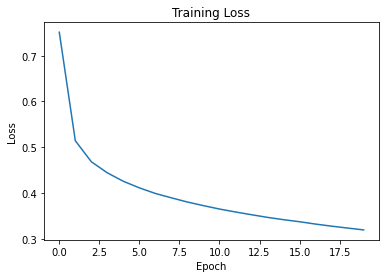

In [96]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Define the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])

# Define the optimizer and loss function
optimizer = keras.optimizers.SGD(learning_rate=0.01)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Define the training step
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = model(images, training=True)
        loss = loss_fn(labels, logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Define the training loop
def train(model, dataset, num_epochs, learning_rate):
    loss_history = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for step, (images, labels) in enumerate(dataset):
            loss = train_step(images, labels)
            epoch_loss += loss
        loss_history.append(epoch_loss/(step+1))
        print('Epoch {}: Loss = {}'.format(epoch+1, loss_history[-1]))
    return loss_history

# Load the fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize the images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Create the train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

# Train the model for 20 epochs
loss_history = train(model, train_dataset, num_epochs=20, learning_rate=0.01)

# Plot the training loss curve
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


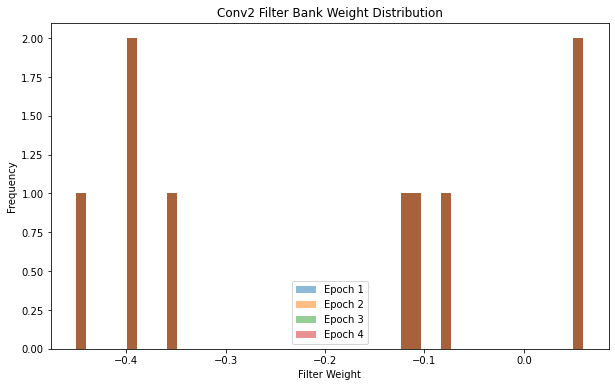

In [128]:
# Plot the filter bank weight distribution for the second convolutional layer
plt.figure(figsize=(10, 6))
for epoch, filters in enumerate(filter_history):
    plt.hist(filters[:, :, :, 0].flatten(), bins=50, alpha=0.5, label=f"Epoch {epoch+1}")
plt.legend()
plt.xlabel("Filter Weight")
plt.ylabel("Frequency")
plt.title("Conv2 Filter Bank Weight Distribution")
plt.show()

# trial

In [100]:
def plot_filters(filter_history):
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, axi in enumerate(ax.flat):
        weights = filter_history[:, :, :, i]
        axi.hist(weights.flatten(), bins=20)
        axi.set_title(f'Filter {i+1}')

    plt.show()


In [103]:
@tf.function
def grad(model, images, labels, loss_fn):
    with tf.GradientTape() as tape:
        logits = model(images, training=True)
        loss_value = loss_fn(labels, logits)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)


In [106]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add a channel dimension to the images
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])

# Define the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Define the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Define the metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Define the training function
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # Make a prediction on the input batch
        logits = model(images, training=True)
        # Compute the loss
        loss = loss_fn(labels, logits)
    # Compute the gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    # Update the weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # Update the metrics
    train_loss(loss)
    train_accuracy(labels, logits)

# Define the test function
@tf.function
def test_step(images, labels):
    # Make a prediction on the input batch
    logits = model(images, training=False)
    # Compute the loss
    loss = loss_fn(labels, logits)
    # Update the metrics
    test_loss(loss)
    test_accuracy(labels, logits)

# Define the training loop
def train(model, train_dataset, num_epochs, learning_rate):
    # Initialize the loss and filter history arrays
    loss_history = []
    filter_history = []
    # Loop over epochs
    for epoch in range(num_epochs):
        # Loop over batches
        for images, labels in train_dataset:
            # Train the model on the batch
            train_step(images, labels)
        # Loop over test data
        for test_images, test_labels in test_dataset:
            # Test the model on the batch
            test_step(test_images, test_labels)
        # Save the loss and accuracy history
        loss_history.append(train_loss.result())
        # Print the loss and accuracy
        print(f'Epoch {epoch + 1}, ' 
              f'Loss: {train_loss.result()}, ' 
              f'Accuracy: {train_accuracy.result() * 100}, ' 
              f'Test Loss: {test_loss.result()}, ' 
              f'Test Accuracy: {test_accuracy.result() * 100}')
        # Reset the metrics for the next
        train_loss.reset_states()
        train_accuracy.reset_states()
def train_step(model, optimizer, x, y, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    gradients = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss.update_state(loss_value)
    train_accuracy.update_state(y, logits)

    return loss_value



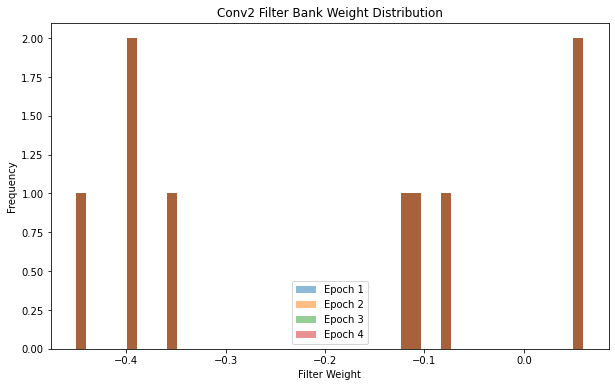

In [126]:
# Plot the filter bank weight distribution for the second convolutional layer
plt.figure(figsize=(10, 6))
for epoch, filters in enumerate(filter_history):
    plt.hist(filters[:, :, :, 0].flatten(), bins=50, alpha=0.5, label=f"Epoch {epoch+1}")
plt.legend()
plt.xlabel("Filter Weight")
plt.ylabel("Frequency")
plt.title("Conv2 Filter Bank Weight Distribution")
plt.show()